In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

'''数据预处理'''

data_dir = 'D:/data'
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图像缩放到 224x224 像素
    transforms.ToTensor(),  # 将图像转换为 PyTorch 张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 对图像进行标准化
])

# 加载数据集
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 按比例划分训练集和测试集，假设80%训练，20%测试
train_size = int(0.8 * len(dataset))  # 80%的数据用于训练
test_size = len(dataset) - train_size  # 剩下的20%用于测试
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 检查是否正确加载数据
classes = dataset.classes  # 获取类名
print(f"Classes: {classes}")
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")


Classes: ['Straight', 'Wavy', 'curly', 'dreadlocks', 'kinky']
训练集大小: 1592
测试集大小: 399


In [10]:
from torchvision import models
# 加载预训练的 GoogLeNet 模型
googlenet = models.googlenet(pretrained=True)
# 打印 GoogLeNet 模型的结构
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

d:\anaconda\envs\env_name\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\env_name\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# 冻结所有层的参数（可选，如果只想微调最后一层）
for param in googlenet.parameters():
    param.requires_grad = False

# 修改最后的全连接层，适应发型分类任务
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, len(classes))

In [7]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=0.001)  # 只训练最后的全连接层


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

epochs = 10  # 可以根据需要调整 epoch 数
for epoch in range(epochs):
    running_loss = 0.0
    googlenet.train()  # 切换到训练模式
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)        
        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # 累加损失
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/10, Loss: 7.975167770385742
Epoch 2/10, Loss: 7.957369613647461
Epoch 3/10, Loss: 7.981940298080445
Epoch 4/10, Loss: 7.948840866088867
Epoch 5/10, Loss: 7.9682974433898925
Epoch 6/10, Loss: 7.974832372665405
Epoch 7/10, Loss: 7.975203685760498
Epoch 8/10, Loss: 7.983399658203125
Epoch 9/10, Loss: 7.9717849922180175
Epoch 10/10, Loss: 7.990303554534912


In [12]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
# 定义与训练时相同的数据预处理步骤
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 将图像从张量转回到 numpy 数组以便 LIME 使用
def tensor_to_numpy(tensor):
    return tensor.permute(1, 2, 0).cpu().numpy()

# 将 numpy 数组转回到张量以便输入模型
def numpy_to_tensor(np_image):
    tensor = torch.from_numpy(np_image).permute(2, 0, 1).float()
    tensor = preprocess_transform(tensor)
    return tensor.unsqueeze(0)  # 加入 batch 维度


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


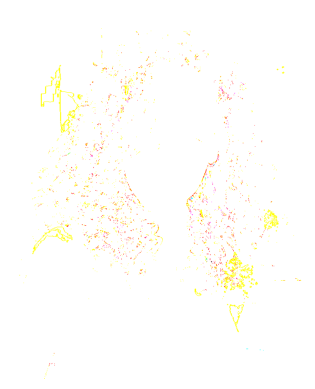

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
'''
解释结果展示：解释结果会突出显示对模型预测最有贡献的区域，通常以颜色块的形式标记。通过这种方式，LIME 可以帮助你理解模型为什么会给出某个分类结果。
调整参数：在 explain_instance 中，你可以调节 num_features（解释中显示的特征数量）和 num_samples（LIME 生成的样本数量）来获得不同的解释效果。
'''
# 加载 LIME Image Explainer
explainer = lime_image.LimeImageExplainer()
# 定义解释函数
def predict_fn(images):
    # 将输入转换为 PyTorch 张量
    inputs = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images]).to(device)  # 转换为 [C, H, W] 形式
    outputs = googlenet(inputs)
    return torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()  # 返回 NumPy 数组
# 选择一个要解释的图像
img_path = r'D:\data\curly\00cbad1ffe22d900018e5a2e7376daed4.jpg'  # 使用原始字符串
img = Image.open(img_path)
# 将 PIL 图像转换为 NumPy 数组
img_np = np.array(img).astype(np.float32)
# 生成 LIME 的解释
explanation = explainer.explain_instance(img_np, predict_fn, top_labels=1, hide_color=0, num_samples=1000)
# 获取解释结果
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
# 显示解释后的图像
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry)
plt.axis('off')
plt.show()